#  Score of handin average questions

I will in this notebook attempt to find the true score of a handin based on handins and graders. The score of each question will be reduced to a single score taken from the average of questions

##  Model

$$ O_{hg} = T_h + B_g $$

$$T_h \sim N(\mu_h, \sigma_h)$$

$$B_g \sim N(\mu_g, \sigma_g)$$


###  Simple model

I will first implement the model for a single handin and see if the model works in a simple version before scalling it up to consider a second dimension.

$$ O_{hg} = T + B_g $$

$$T \sim N(\mu, \sigma)$$

$$B_g \sim N(\mu_g, \sigma_g)$$


In [881]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import copy

In [767]:
def simple_model(data):
    N = len(data)

    # True score
    T_mu = pm.Uniform('T_mu',0,1)
    T = pm.Normal('T', mu=T_mu, tau=100, value = np.mean(data))

    # Bias
    B = list()
    O = list()

    for i in range(0, N):
        B.append(pm.Normal('B_%i' % i, mu=0, tau=100))
        O.append(pm.Normal('O_%i' % i, mu = T + B[i], tau=100, observed=True, value=data[i]))
            
    collection = [T,
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(4000)
    return mcmc

##  Data

This section is about getting hold of the relevant data needed for fitting our model

In [90]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [91]:
def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

In [92]:
def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

In [93]:
def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

In [94]:
def answer_with_score(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    return 'text_answer' not in answer

In [95]:
def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'] })
    handin_acc = 0.0
    for answer in answers:
        if answer_with_score(answer['_id']):
            handin_acc = handin_acc + answer_value(answer['_id'])
    return handin_acc / float(answers.count())

In [163]:
print score_handin_grader(ObjectId("5609b22e1bd43a000fb12328"),ObjectId("55d9cb9ea6fb8f00080da492"))

0.675213675214


In [164]:
def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

We know have the capabilities to easily get the average score from all the graders of a handin

In [22]:
print score_handin_list(ObjectId("5609b2d71bd43a000fb1232a"))

[(0.5726495726495726, ObjectId('55e4330ded7a0c0009f0d9d9')), (0.6410256410256411, ObjectId('55f2d136d8786100099ff332')), (0.5128205128205128, ObjectId('55db3833edf3950009412132')), (0.46153846153846156, ObjectId('55e59e8336cc7d00092c414a')), (0.6410256410256411, ObjectId('55d9cb9ea6fb8f00080da473')), (0.6153846153846154, ObjectId('55db3833edf395000941213d')), (0.4871794871794871, ObjectId('56056a8689c698000f9c29bd')), (0.4957264957264957, ObjectId('55db3832edf395000941211a'))]


##  Fitting

In [ ]:
data = np.array(score_handin_list(ObjectId("5609b2d71bd43a000fb1232a")))

In [768]:
print data

[(0.2726495726495726, ObjectId('55e4330ded7a0c0009f0d9d9')), (0.6410256410256411, ObjectId('55f2d136d8786100099ff332')), (0.5128205128205128, ObjectId('55db3833edf3950009412132')), (0.46153846153846156, ObjectId('55e59e8336cc7d00092c414a')), (0.6410256410256411, ObjectId('55d9cb9ea6fb8f00080da473')), (0.6153846153846154, ObjectId('55db3833edf395000941213d')), (0.4871794871794871, ObjectId('56056a8689c698000f9c29bd')), (0.9957264957264957, ObjectId('55db3832edf395000941211a'))]


In [769]:
data = [(0.2726495726495726, ObjectId('55e4330ded7a0c0009f0d9d9')),
 (0.6410256410256411, ObjectId('55f2d136d8786100099ff332')),
 (0.5128205128205128, ObjectId('55db3833edf3950009412132')),
 (0.46153846153846156, ObjectId('55e59e8336cc7d00092c414a')),
 (0.6410256410256411, ObjectId('55d9cb9ea6fb8f00080da473')),
 (0.6153846153846154, ObjectId('55db3833edf395000941213d')),
 (0.4871794871794871, ObjectId('56056a8689c698000f9c29bd')),
 (0.9957264957264957, ObjectId('55db3832edf395000941211a'))]

In [770]:
data_ = map(lambda x: x[0],data)
mcmc = simple_model(data_)

 [-----------------100%-----------------] 4000 of 4000 complete in 4.6 sec

Plotting T


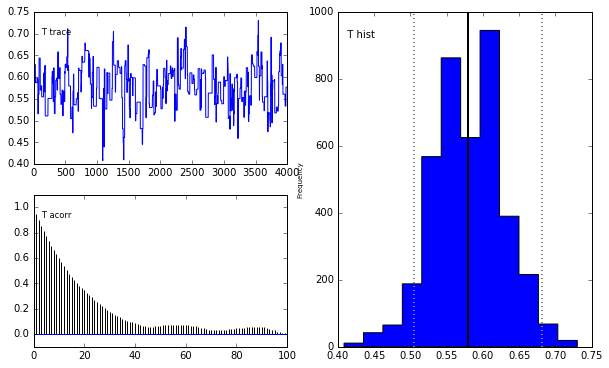

In [771]:
mcplot(mcmc.trace('T'))

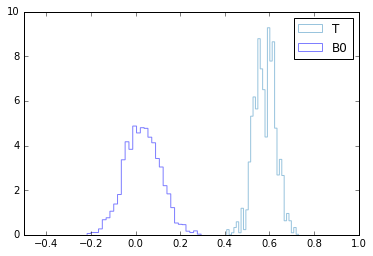

In [772]:
T = mcmc.trace("T")[:]
plt.hist(T, histtype="step", normed=True, alpha=0.5, bins=30,
         label="T", color="#348ABD")
B0 = mcmc.trace("B_1")[:]
plt.hist(B0, histtype="step", normed=True, alpha=0.5, bins=30,
         label="B0")
plt.xlim(-0.5,1)
plt.legend()
plt.show()

In [773]:
print "The mean value of the observed data:"
print np.mean(data_)
print "The expected value of the normal distribution of T, the true score:"
print np.mean(T)
print "The expected value of the normal distribution of the bias of the first grader B0:"
print data_[1]
print np.mean(B0)

The mean value of the observed data:
0.578418803419
The expected value of the normal distribution of T, the true score:
0.580013338583
The expected value of the normal distribution of the bias of the first grader B0:
0.641025641026
0.0309245647129


the true_score and the mean of the observed data is not far from eachother and implies that the model works as we want

Biases of all the grader

<function matplotlib.pyplot.show>

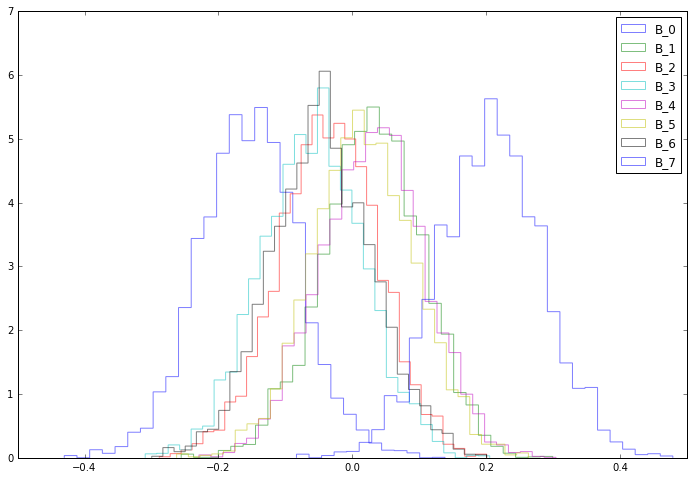

In [300]:
ax = plt.subplot(111)

for i in range(0,8):
    B = mcmc.trace("B_%i" % i)[:]
    ax.hist(B, histtype="step", normed=True, alpha=0.5, bins=30,
         label="B_%i" % i)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 2, box.height * 2])

plt.xlim(-0.5,0.5)
plt.legend()
plt.show

In [301]:
for i in range(0,8):
    print np.mean(mcmc.trace("B_%i" % i)[:])

-0.153158052144
0.0296234368984
-0.0353653234874
-0.0594052899258
0.0299928063209
0.0164452381059
-0.0457151586111
0.207108310523


What is interresting here is that the expected value of each bias is not far from each other and lies close to zero. The varance however is not the same and some observations such as B_6 and B_2 have the largest varaince so they may have more bias than others.

The precision of true_score increases as more data points are added

In [ ]:
ax = plt.subplot(111)

for i in range(1,9):    
    mcmc = simple_model(data[0:i])
    trace_T = mcmc.trace("T")[:]
    ax.hist(trace_T, histtype="step", normed=True, alpha=0.5, bins=30,
         label="%i obs" % i)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 2, box.height * 2])

plt.xlim(-5,5)
plt.legend()
plt.show


From the plot we can see that the first iteration with one observation as very high variance. at 3 observations the varaince have stabalised and more observations does not reduce the variance

# Model with handins

## Fetching Data

In [581]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

In [582]:
data_handin = assignment_handins(ObjectId("55f277cff3bd61000a2112d4"))

In [1109]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    O = list()

    for h in range(0, N_H):
        (scores,h_id) = data[h]
        N_G = len(scores)
        
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=np.mean(map(lambda x:x[0],scores)), tau=100)
        
        for g in range(0, N_G):
            (val,g_id) = scores[g]
            if g_id not in B:
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=0, tau=100) 
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [1110]:
def execute_model(model):
    mcmc = pm.MCMC(model)
    mcmc.sample(5000,500)
    return mcmc

###  Validation

The main problem with probabilitis programming is the solution is not always the same so we can validte how precise the model is at finding a correct solution after running the data a two times and compare the found solutions against eachother

In [1135]:
model_ = handin_model(data_handin)

In [1145]:
mcmc_handin = execute_model(model_)

 [-----------------100%-----------------] 5000 of 5000 complete in 193.2 sec

In [1146]:
mcmc_handin2 = execute_model(model_)

 [-----------------100%-----------------] 5000 of 5000 complete in 167.5 sec

In [1147]:
mcmc_handin3 = execute_model(model_)

 [-----------------100%-----------------] 5000 of 5000 complete in 164.1 sec

In [996]:
def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

In [1188]:
def grader_id(grader_name):
    grader = db.user.find_one({'name': grader_name})
    return grader['_id']

In [997]:
def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

In [1181]:
def find_bias(assignment_id,mcmc,f):
    bias_abs = list()
    for g in grader_ids(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
            name = str(g)
            bias_abs.append((bias_mean,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return bias_abs

In [1191]:
def number_of_reports(user_name, assignment_id):
    user = db.user.find_one({'name': user_name })
    reports = db.report_grade.find({'assignment': assignment_id, 'giver': user['_id'], 'state': 'ANSWERED'})
    return reports.count()

In [1189]:
grader_id('Gandalf Saxe')

ObjectId('55e4330ded7a0c0009f0d9dc')

The first option is to compare the mean of the bias by ranking all graders by from the least bias to the most by the mean value of their bias distribution from 0 between two sample runs

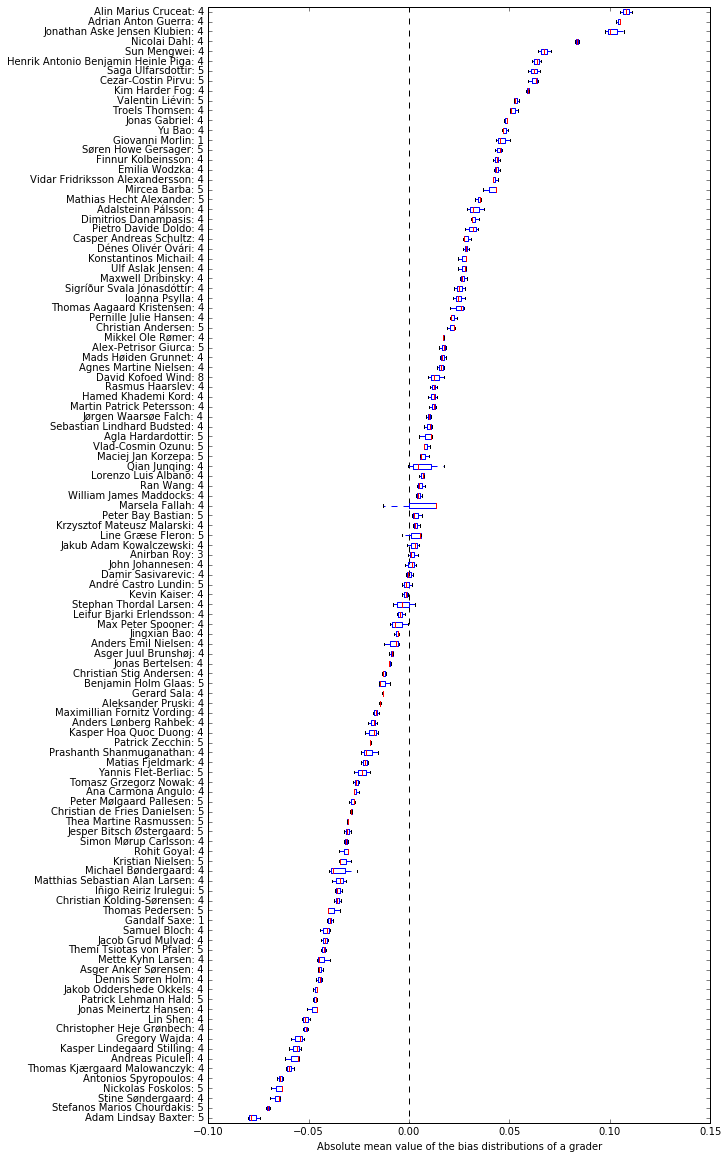

In [1192]:
# find the mean bias of the two runs
bias_abs_1 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin, np.mean)
bias_abs_2 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin2, np.mean)
bias_abs_3 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin3, np.mean)

# Generate dict of the found values in each run for each grader
compared = defaultdict(list)
collected = list()
collected = bias_abs_1[:]
collected.extend(bias_abs_2[:])
collected.extend(bias_abs_3[:])
for (value, _id) in collected:
    compared[_id].append(value)

# Produce a box plot where the graders are sorted after mean value of the found values
ax = plt.subplot(111)

#largest_diff = 0
#largest_diff_id = ""

sorted_list = compared.items()
sorted_list.sort(key=lambda x: np.mean(x[1][:]))

#y_axis = list()
#y_values = list()

labels = list()
for (_id, value) in sorted_list:
    name = grader_name(ObjectId(_id))
    reported = number_of_reports(name, ObjectId("55f277cff3bd61000a2112d4"))
    labels.append(name + ": " + str(reported))
    
values = map(lambda x: x[1], sorted_list)
plt.boxplot(values,0, vert=False, labels=labels)
#for idx, (_id, values) in enumerate(sorted_list):
#    idx = idx * 2 
#    bias1, bias2 = values[0], values[1]
#    if bias1 > bias2:
#        plt.plot([bias1,bias2],[idx,idx], color='g')
#        plt.plot(bias2,idx,'o', color='b', alpha=0.5)
#    else:
#        plt.plot([bias1,bias2],[idx,idx], color='r')
#        plt.plot(bias2,idx,'o', color='b', alpha=0.5)
#    y_axis.append(idx)
#    y_values.append(grader_name(ObjectId(_id)))
#    if abs(bias1-bias2) > largest_diff:
#        largest_diff = abs(bias1-bias2)
#        largest_diff_id = _id

# plt.yticks(y_axis, y_values)
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*5])
plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
plt.xlabel("Absolute mean value of the bias distributions of a grader")
plt.show()

We can see that the moel does not find the same solution. Some graders does have a mean bias very similair to the previous run and others have a very large change in their bias. 

Next we can do the same with the variance of the bias instead of t

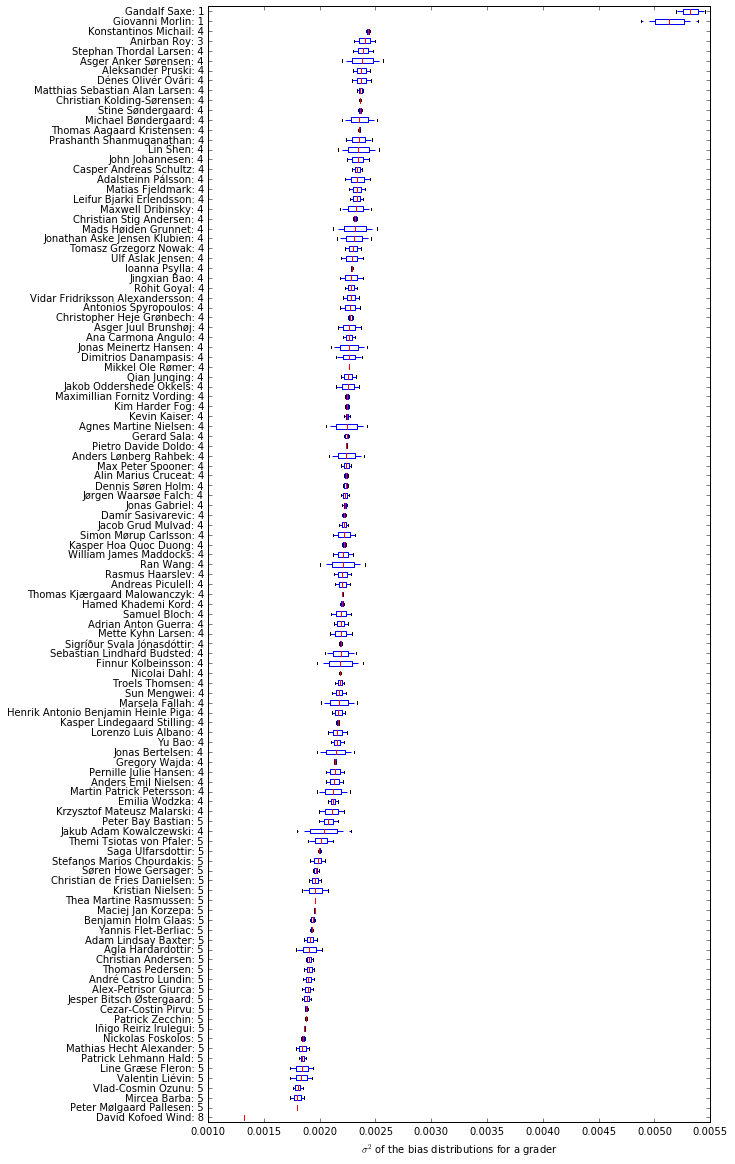

In [1193]:
# find the mean bias of the two runs
bias_abs_1 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin, np.var)
bias_abs_2 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin2, np.var)
bias_abs_3 = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_handin3, np.var)

# Generate dict of the found values in each run for each grader
compared = defaultdict(list)
collected = list()
collected = bias_abs_1[:]
collected.extend(bias_abs_2[:])
for (value, _id) in collected:
    compared[_id].append(value)

# Produce a box plot where the graders are sorted after mean value of the found values
ax = plt.subplot(111)

#largest_diff = 0
#largest_diff_id = ""

sorted_list = compared.items()
sorted_list.sort(key=lambda x: np.mean(x[1][:]))

#y_axis = list()
#y_values = list()

labels = list()
for (_id, value) in sorted_list:
    name = grader_name(ObjectId(_id))
    reported = number_of_reports(name, ObjectId("55f277cff3bd61000a2112d4"))
    labels.append(name + ": " + str(reported))

values = map(lambda x: x[1], sorted_list)
plt.boxplot(values,0, vert=False, labels=labels)
#for idx, (_id, values) in enumerate(sorted_list):
#    idx = idx * 2 
#    bias1, bias2 = values[0], values[1]
#    if bias1 > bias2:
#        plt.plot([bias1,bias2],[idx,idx], color='g')
#        plt.plot(bias2,idx,'o', color='b', alpha=0.5)
#    else:
#        plt.plot([bias1,bias2],[idx,idx], color='r')
#        plt.plot(bias2,idx,'o', color='b', alpha=0.5)
#    y_axis.append(idx)
#    y_values.append(grader_name(ObjectId(_id)))
#    if abs(bias1-bias2) > largest_diff:
#        largest_diff = abs(bias1-bias2)
#        largest_diff_id = _id

# plt.yticks(y_axis, y_values)
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*5])
plt.xlabel(r'$\sigma^2$ of the bias distributions for a grader')
plt.show()

We can see here that the variance of the distribtuions are very close to each other which makes the value vary greatly between each run of the model. But there are 

We can next compare it with the found ranking of the mean of the graders with the ranking that Thomas Pedersen have found.

In [805]:
weights = list()
with open('Data/weight.txt') as f:
    for line in f:
        weights.append(line[:-1])

In [806]:
compared = list()
for idx, (value, _id) in enumerate(bias_abs):
    if _id in weights:
        compared.append((_id ,idx, weights.index(_id)))

In [807]:
compared.sort(key=lambda x:abs(x[2]-x[1]))

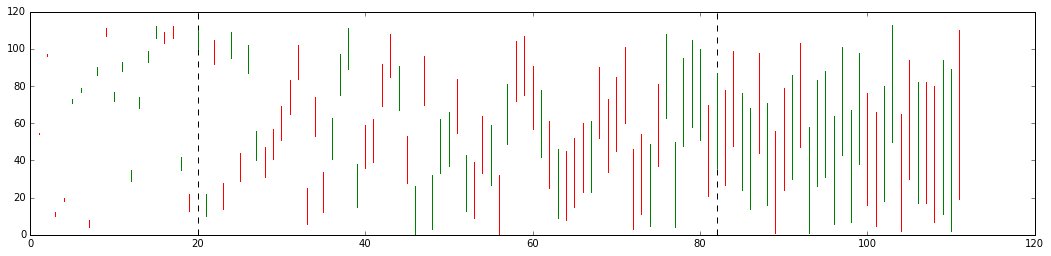

In [808]:
ax = plt.subplot(111)

dis_ten = 0
dis_fifty = 0

for idx, (_id, bias,weight) in enumerate(compared):
    if bias > weight:
        plt.plot([idx,idx],[bias,weight], color='r')
    else:
        plt.plot([idx,idx],[bias,weight], color='g')
    if dis_ten == 0 and abs(bias-weight) >= 10:
        dis_ten = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)
    if dis_fifty == 0 and abs(bias-weight) >= 50:
        dis_fifty = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)

    
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 3, box.height])
    
plt.show()

Here I have plotted the difference between the ranking I have found and the ranking Thomas Pedersen have found. The difference is defined by a line where the y axis defines the ranking where 0 is best and 121 is the worst ranked.
A green line indicates that Thomas have granted the grader a larger ranking than I and red is the opposite
The x axis defines the graders, and is sorted after the graders with the least difference in ranking.

It is clear that there are no corroloation, but this is somewhat to be expected as Thomas Pedersen find his through completely other means. Additionally his is based on the entire course "Computational tools for big data" where mine is only on one assignment

## Full scale data

Next i use the same model, but this time on the handins of an entire course instead of a single assignment.

### Fetching data

In [594]:
def course_handins(course_id):
    handins = list()
    assignments = db.assignment.find({'course':course_id})
    for assignment in assignments:
        handins.extend(assignment_handins(assignment['_id']))
    return handins

### Model

We can use the same model as before

In [595]:
data_course = course_handins(ObjectId("55d9cb9ea6fb8f00080da4a1"))

In [625]:
mcmc_course = handin_model(data_course)

 [-----------------100%-----------------] 15000 of 15000 complete in 2126.1 sec

We can comapre the found bias as before with the found value of Thomas's findings

In [818]:
bias_abs_c = find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc_course, np.mean)
bias_abs_c.sort()

error
error


In [819]:
len(bias_abs_c)

114

In [820]:
weights = list()
with open('Data/weight.txt') as f:
    for line in f:
        weights.append(line[:-1])

In [821]:
compared_c = list()
for idx, (value, _id) in enumerate(bias_abs_c):
    if _id in weights:
        compared_c.append((_id ,idx, weights.index(_id)))

In [822]:
compared_c.sort(key=lambda x:abs(x[2]-x[1]))

In [823]:
len(compared_c)

113

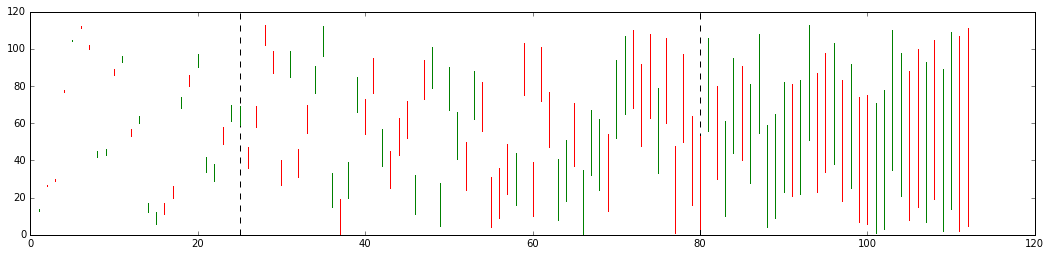

In [824]:
ax = plt.subplot(111)

dis_ten = 0
dis_fifty = 0

for idx, (_id, bias,weight) in enumerate(compared_c):
    if bias > weight:
        plt.plot([idx,idx],[bias,weight], color='r')
    else:
        plt.plot([idx,idx],[bias,weight], color='g')
    if dis_ten == 0 and abs(bias-weight) >= 10:
        dis_ten = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)
    if dis_fifty == 0 and abs(bias-weight) >= 50:
        dis_fifty = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 3, box.height])
    
plt.show()

We can also compare the found bias with the ones found in the model for only a single assignment and see if more assignments have changed the ranking of the students

In [825]:
compared_cn = list()
for idx, (value, _id) in enumerate(bias_abs_1):
    for item in enumerate(bias_abs_c):
        if item[1][1] == _id:
            compared_cn.append((_id ,idx, item[0]))

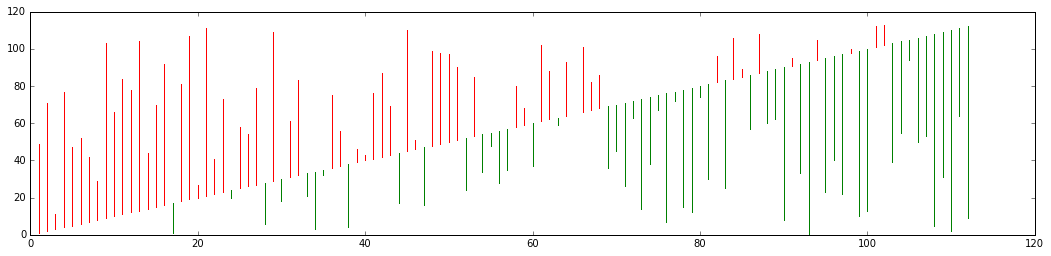

In [827]:
ax = plt.subplot(111)

dis_ten = 0
dis_fifty = 0

for idx, (_id, bias,weight) in enumerate(compared_cn):
    if bias > weight:
        plt.plot([idx,idx],[bias,weight], color='g')
    else:
        plt.plot([idx,idx],[bias,weight], color='r')

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 3, box.height])
    
plt.show()

Form the plot we can see that there are large changes to the mean as soon as more assignments were added to the model.